In [3]:
import os
import glob

import tables as tb
import numpy  as np
import pandas as pd

from collections import defaultdict
from scipy import interpolate

In [4]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook
%matplotlib inline
### Useful parameters for plots
mpl.rcParams["figure.figsize"]          = 12,10
mpl.rcParams["font.size"]               = 20
mpl.rcParams["figure.max_open_warning"] = 100
mpl.rcParams["font.size"]               = 20
mpl.rcParams["font.weight"]             ='normal'
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w';

In [98]:
fileruns  = [22, 235, 620, 701, 1073]
run0      = [0] + fileruns[1:]
runend    = fileruns[1:] + [10000]

dates = ['16 Feb 2024', '27 Mar 2024', '17 May 2024', '7 Jun 2024', '1 Jul 2024']

mode = '1PE'

colnames = ['amp_p0', 'amp_p0_e', 'mu_p0', 'mu_p0_e', 'sigma_p0', 'sigma_p0_e',
            'amp_p1', 'amp_p1_e', 'mu_p1', 'mu_p1_e', 'sigma_p1', 'sigma_p1_e',
            'amp_p2', 'amp_p2_e', 'mu_p2', 'mu_p2_e', 'sigma_p2', 'sigma_p2_e']

colnames = colnames if mode =='2PE' else colnames[:12]
datapath  = '/home/ander/Work/GaP/notebooks/Calibration/Calibration_Constants/'
tablepath = '/home/ander/Work/GaP/notebooks/Calibration/CreateTables/config/GaP_gains/'

datasets = []

pmt_pos = [(0      ,0      ,-30.3),             
           (36.253 ,2.949  ,-30.3),  
           (-15.573,-32.871,-30.3),
           (-20.68 ,29.922 ,-30.3), 
           (20.68  ,-29.922,-30.3),   
           (-36.253,-2.949 ,-30.3),  
           (15.573 ,32.871 ,-30.3)]

for run, date, r0, r1 in zip(fileruns, dates, run0, runend):
    dst = pd.read_csv(glob.glob(f'{datapath}/calibrun_{run}-*_parameters_{mode}fit.txt')[0], 
                      names=colnames, delimiter='\s+', skiprows=0, 
                      dtype='float').rename_axis('PMT ID').reset_index()
    dst['date'  ] = pd.to_datetime(np.full(len(dst), date), format="%d %b %Y")#.strftime("%d/%m/%Y")
    dst['gain'  ] = dst['mu_p1'] - dst['mu_p0']
    dst['gain_e'] = np.sqrt(dst['mu_p1_e']**2 + dst['mu_p0_e']**2)
    datasets.append(dst)
    
    config_string = ''
    for pos, d in zip(pmt_pos, dst.iterrows()):
        config_string+=f'PMT {d[0]:.0f}  ({pos[0]},{pos[1]},{pos[2]})\t\t({d[1]["gain"]:.2f},{d[1]["gain_e"]:.2f},{d[1]["sigma_p1"]:.2f},{d[1]["sigma_p1_e"]:.2f})\n'
    
    with open(f"{tablepath}GaP.sensors_MinRun_{r0}_MaxRun_{r1}.txt", "w") as text_file:
        print(config_string, file=text_file)

datasets = pd.concat(datasets).reset_index(drop=True)

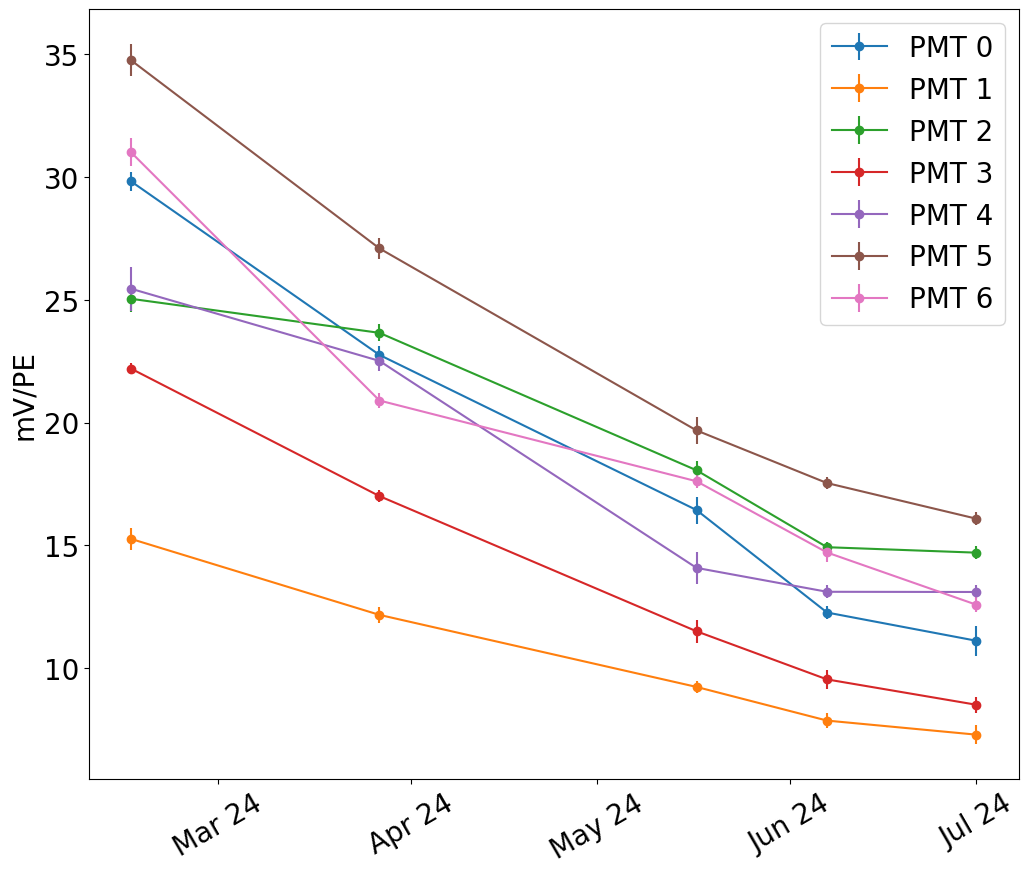

In [71]:
for ipmt in range(7):
    sel = datasets['PMT ID'] == ipmt
    plt.errorbar(datasets[sel]['date'], datasets[sel]['gain'], yerr=datasets[sel]['gain_e'],
                 label=f'PMT {ipmt}', marker='o')
    
plt.legend()
plt.ylabel('mV/PE')

ax = plt.gca()
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
#ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %y"))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='center')
#plt.t

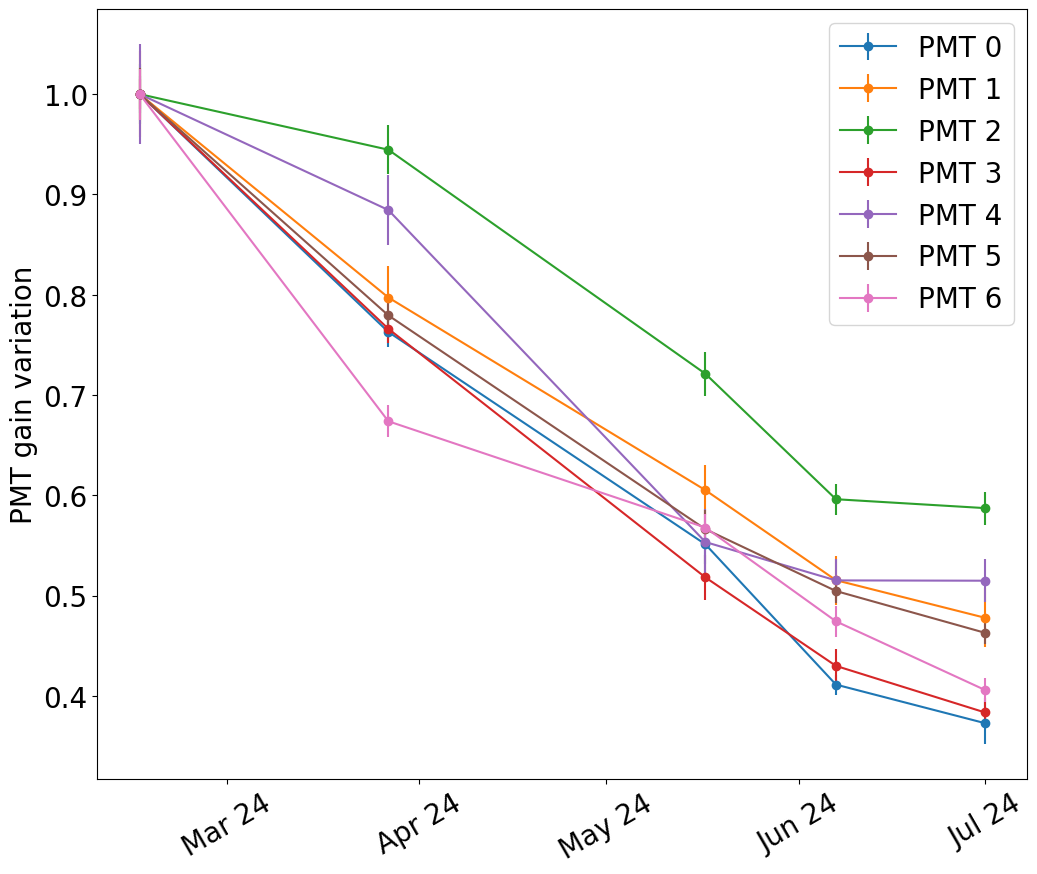

In [77]:
for ipmt in range(7):
    sel = datasets['PMT ID'] == ipmt
    grat   = datasets[sel]['gain']/datasets[sel]['gain'].values[0]
    grat_e = np.sqrt((datasets[sel]['gain_e']/datasets[sel]['gain'])**2  + (datasets[sel]['gain_e'].values[0]/datasets[sel]['gain'].values[0])**2)*grat
    plt.errorbar(datasets[sel]['date'], grat, yerr=grat_e,
                 label=f'PMT {ipmt}', marker='o')
    
plt.legend()
plt.ylabel('PMT gain variation')

ax = plt.gca()
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
#ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %y"))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='center')

plot_path = '/home/ander/Documents/ESS/GanESS/GaP/DetectorPaper/'
plt.savefig(plot_path+'PMT_Gain_Variation.pdf',dpi=200)
#plt.t